### Imports and Definitions

In [1]:
from csv import reader as csv_reader
from glob import glob
from gzip import open as gopen
from math import log10
from matplotlib import rcParams
from os import makedirs
from os.path import isfile
from pickle import dump as pdump
from pickle import load as pload
from seaborn import pointplot, set_context, set_style, violinplot
import matplotlib.pyplot as plt
ZERO_THRESH = 0.0000000001
DATADIR = '../data'
FIGDIR = '../figs'; makedirs(FIGDIR, exist_ok=True)
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'
rcParams['patch.edgecolor'] = '4C4C4C' # set boxenplot outlines same as violinplot

### Load AWS EC2 Instance Costs

In [2]:
# load existing EC2 instance costs (if any exist)
instance_cost_fn = '%s/sarscov2/costs/instance_cost.pkl.gz' % DATADIR
if isfile(instance_cost_fn):
    instance_cost = pload(gopen(instance_cost_fn,'rb'))
else:
    instance_cost = dict()

# update if there are any new CSVs
modified = False
for costfn in glob('%s/sarscov2/costs/AWS_ANALYZE*.csv' % DATADIR):
    for row in csv_reader(open(costfn)):
        if len(row) != 0 and 'i-' in row[0]:
            instanceID = 'i-%s' % row[0].split('i-')[-1].rstrip(')').strip()
            cost = float(row[-1])
            if instanceID in instance_cost:
                if instance_cost[instanceID] < cost:
                    instance_cost[instanceID] = cost; modified = True
            else:
                instance_cost[instanceID] = cost; modified = True
if modified:
    f = gopen(instance_cost_fn,'w'); pdump(instance_cost,f); f.close()

### Helper: Convert Power of 10 to Scientific Notation

In [3]:
def sci_not_mult10(n):
    p = log10(n)
    assert abs(p-int(p)) < ZERO_THRESH, "Not a power of 10: %s" % n
    return r'$10^%d$' % p

### Helper: Get Walltime from GNU `time` Output

In [4]:
def walltime_from_time(path):
    tl = [l.strip().split()[-1].strip() for l in open(path) if l.startswith('real')]
    assert len(tl) == 1, "Multiple lines starting with 'real' in: %s" % path
    m = int(tl[0].split('m')[0])
    s = float(tl[0].split('m')[1].rstrip('s'))
    return 60*m + s

### Plot Runtime vs. *n*

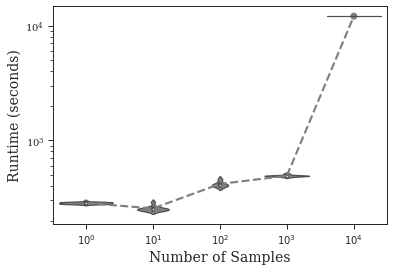

In [5]:
# load benchmarking runtimes
time_vs_n_data = {'n':list(), 'time':list()}
for ndir in glob('%s/sarscov2/n*' % DATADIR):
    n = int(ndir.split('/')[-1].lstrip('n'))
    for rdir in glob('%s/r*' % ndir):
        if isfile('%s/time.txt' % rdir):
            time_vs_n_data['n'].append(sci_not_mult10(n))
            time_vs_n_data['time'].append(walltime_from_time('%s/time.txt' % rdir))

# generate plot
fig, ax = plt.subplots()
pointplot(x=time_vs_n_data['n'], y=time_vs_n_data['time'], linestyles='--', color='grey')
violinplot(x=time_vs_n_data['n'], y=time_vs_n_data['time'], color='grey')
ax.set_yscale('log')
plt.xlabel('Number of Samples')
plt.ylabel('Runtime (seconds)')
fig.savefig('%s/runtime.pdf' % FIGDIR, format='pdf', bbox_inches='tight')

### Plot Cost vs. *n*

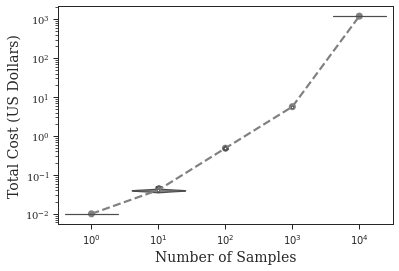

In [6]:
# load benchmarking costs
cost_vs_n_data = {'n':list(), 'usd':list()}
for ndir in glob('%s/sarscov2/n*' % DATADIR):
    n = int(ndir.split('/')[-1].lstrip('n'))
    for rdir in glob('%s/r*' % ndir):
        if rdir.endswith('.zip'):
            continue
        tmp = list(glob('%s/reflow_logs/*.syslog' % rdir))
        if len(tmp) == 0:
            continue
        assert len(tmp) == 1, "Invalid folder structure for reflow logs"
        instances = [l.split(' ')[4].strip() for l in open(tmp[0]) if ' discovered instance ' in l]
        cost = 0
        for instanceID in instances:
            assert instanceID in instance_cost, "Instance not found: %s" % instanceID
            cost += instance_cost[instanceID]
        cost_vs_n_data['n'].append(sci_not_mult10(n))
        cost_vs_n_data['usd'].append(max(cost, 0.01))
        

# generate plot
fig, ax = plt.subplots()
pointplot(x=cost_vs_n_data['n'], y=cost_vs_n_data['usd'], linestyles='--', color='grey')
violinplot(x=cost_vs_n_data['n'], y=cost_vs_n_data['usd'], color='grey')
plt.xlabel('Number of Samples')
plt.ylabel('Total Cost (US Dollars)')
ax.set_yscale('log')
fig.savefig('%s/cost.pdf' % FIGDIR, format='pdf', bbox_inches='tight')